# Learning Cuves

---

__This Notebook__

- plot learning curves to assess how gradient boosting models are training and whether they're overfitting
- start with best two classifiers and tweak them little by little to see if their learning improves

__Results__ 







## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split, \
    ShuffleSplit, StratifiedKFold, learning_curve
from sklearn.metrics import make_scorer, accuracy_score, \
    recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-14


## Load

In [2]:
# load target 
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())
y = y_array.copy()
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X = sp.load_npz(os.path.join(proc_dir, 
                             'X_tfidf_svd800_spamcos.npz'))

## Functions

In [3]:
def train_plot(clf, X, y, cv, verbose, train_sizes, n_jobs, 
               scorer_, metric, axes, axis):
    """
    Trains and plots learning_curves, given:
        scorer_: a make_scorer object
        metric: str, the name of the metric
    ...and all other args passed to learning_curve in the 
    plot_learning_curve function.
    """
    # train
    train_sizes, train_scores, test_scores = \
        learning_curve(clf, X, y, cv=cv, verbose=verbose,
                       train_sizes=train_sizes, n_jobs=n_jobs,
                       scoring=scorer_)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)    
    
    # plot
    axes[axis].grid()
    axes[axis].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[axis].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[axis].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[axis].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[axis].legend(loc="lower right")
    axes[axis].set_ylabel(metric)

In [4]:
def plot_learning_curve(clf, title, X, y, axes=None, ylim=(.95, 1.01), 
                        cv=5, train_sizes=np.linspace(.1, 1.0, 5),
                        verbose=0, n_jobs=-1):
    """
    Adapted from the Plot Learning Curves example in Scikit-Learn 
    to show only the performance of a scorer, using accuracy, 
    sensitivity, and specificity as metrics.
    """
    # set axes, title, ylims, xlabel
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 12))
    
    axes[0].set_title(title)
    axes[2].set_xlabel("Training Examples")
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
        axes[1].set_ylim(*ylim)
        axes[2].set_ylim(*ylim)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity
        'tnr': make_scorer(recall_score, pos_label=0) # specificity
    }

    # plots
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['acc'], metric='Accuracy', 
               axes=axes, axis=0)
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['tpr'], metric='Sensitivity', 
               axes=axes, axis=1)
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['tnr'], metric='Specificity', 
               axes=axes, axis=2)
    
    return plt

In [5]:
def compare_two_classifiers(clf1, clf2, title1, title2):
    """
    Wrapper for plot_learning_curve with a timer.
    Compares two classifiers' learning curves.
    """
    t = time.time()
    fig, axes = plt.subplots(3, 2, figsize=(16, 16))
    plot_learning_curve(clf1, title1, X, y, axes=axes[:, 0], cv=cv)
    plot_learning_curve(clf2, title2, X, y, axes=axes[:, 1], cv=cv)
    m, s = divmod(time.time() - t, 60)
    print(f'Elapsed: {m:0.0f} m {s:0.0f} s')
    plt.show()     

## Comparison plots

The two classifiers I begin with are the best from the gradient boosting notebooks 2 and 3. 

- Clf1 has 50 trees, 3000 features, max depth 1, min samples split 2
- Clf2 has 100 trees, 300 features, max depth 8, min samples split 5
- Both have a learning rate $\eta=0.1$

In [6]:
# 10-fold cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [7]:
# define classifiers
title1 = r"50 trees, 3000 feat, depth 1, split 2, $\eta=0.1$"
title2 = r"100 trees, 300 feat, depth 8, split 5, $\eta=0.1$"

clf1 = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=None, # default, all (3000)
    max_depth=1,
    min_samples_split=2, # default
    learning_rate=0.1 # default
)

clf2 = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=100, # default
    max_features=300,
    max_depth=8, 
    min_samples_split=5, 
    learning_rate=0.1 # default
)

Elapsed: 27 m 51 s


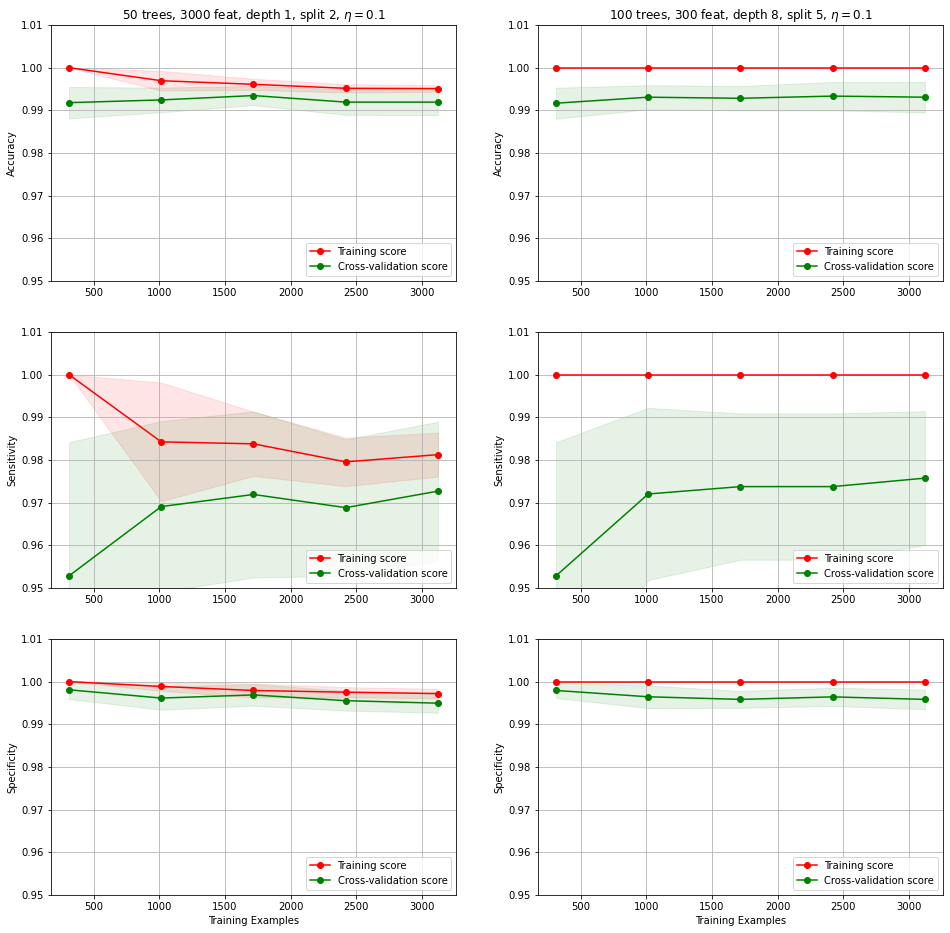

In [8]:
compare_two_classifiers(clf1, clf2, title1, title2)

__Results__


Clf1 learns better: its training curves adapt and stop overfitting, unlike Clf2's training curves, so I believe it will generalize better.

One hypothesis is because it uses less trees and/or shallower trees, but note it uses all features and a lower min samples split.

__Next__

- I raise Clf1's learning rate to 1 to test whether training and validation curves will converge faster (for TPR mostly)
- I lower Clf2's max depth to see if it stops overfitting


In [9]:
title1b = r"50 trees, 3000 feat, depth 1, split 2, $\eta=1.0$"
title2b = r"100 trees, 300 feat, depth 3, split 5, $\eta=0.1$"

clf1b = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=None,
    max_depth=1,
    min_samples_split=2,    
    learning_rate=1 # raised
)

clf2b = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=100,
    max_features=300, 
    max_depth=3, # lowered
    min_samples_split=5, 
    learning_rate=0.1
)

Elapsed: 13 m 34 s


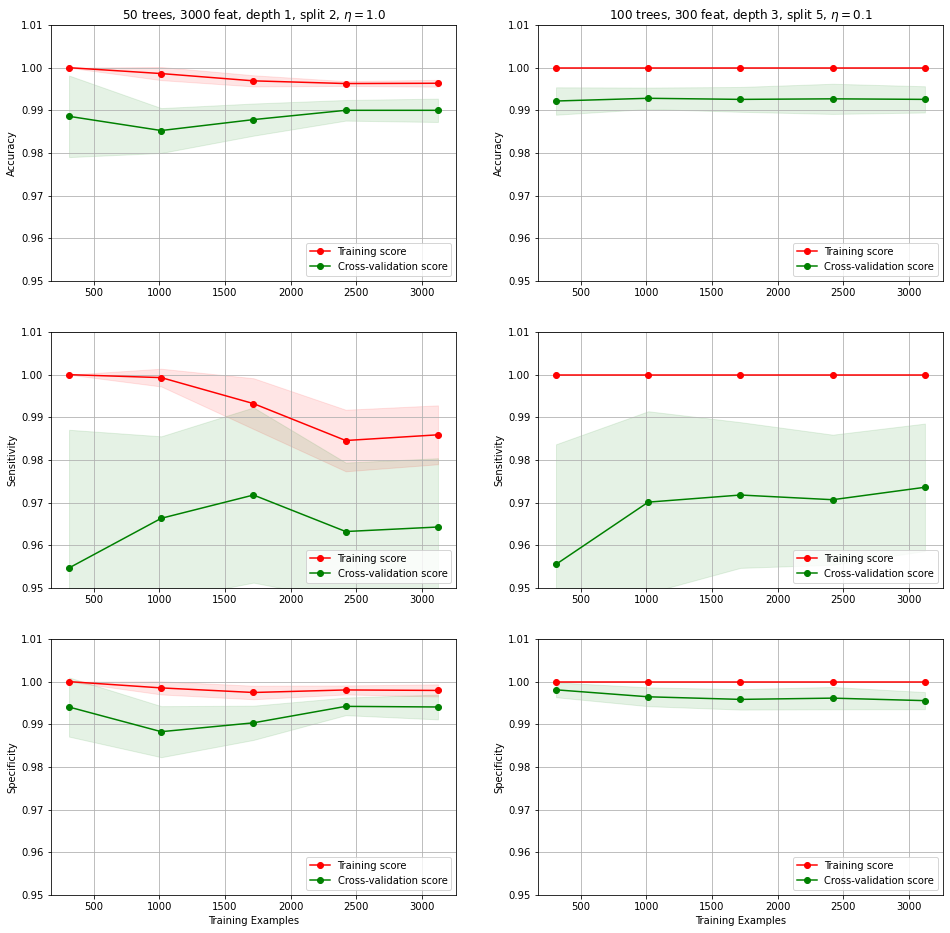

In [10]:
compare_two_classifiers(clf1b, clf2b, title1b, title2b)

__Results__

- Clf1b's curves converge even less
- Clf2b still overfits, the max depth change did not affect results

__Next__

- lower the learning rate for Clf1 instead (from the original 0.1 to 0.01)
- lower the number of trees in Clf2b


In [12]:
title1c = r"50 trees, 3000 feat, depth 1, split 2, $\eta=0.01$"
title2c = r"50 trees, 300 feat, depth 3, split 5, $\eta=0.1$"

clf1c = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=None,
    max_depth=1,
    min_samples_split=2,    
    learning_rate=0.01 # lowered
)

clf2c = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50, # lowered
    max_features=300,
    max_depth=3,
    min_samples_split=5,    
    learning_rate=0.1
)

Elapsed: 8 m 59 s


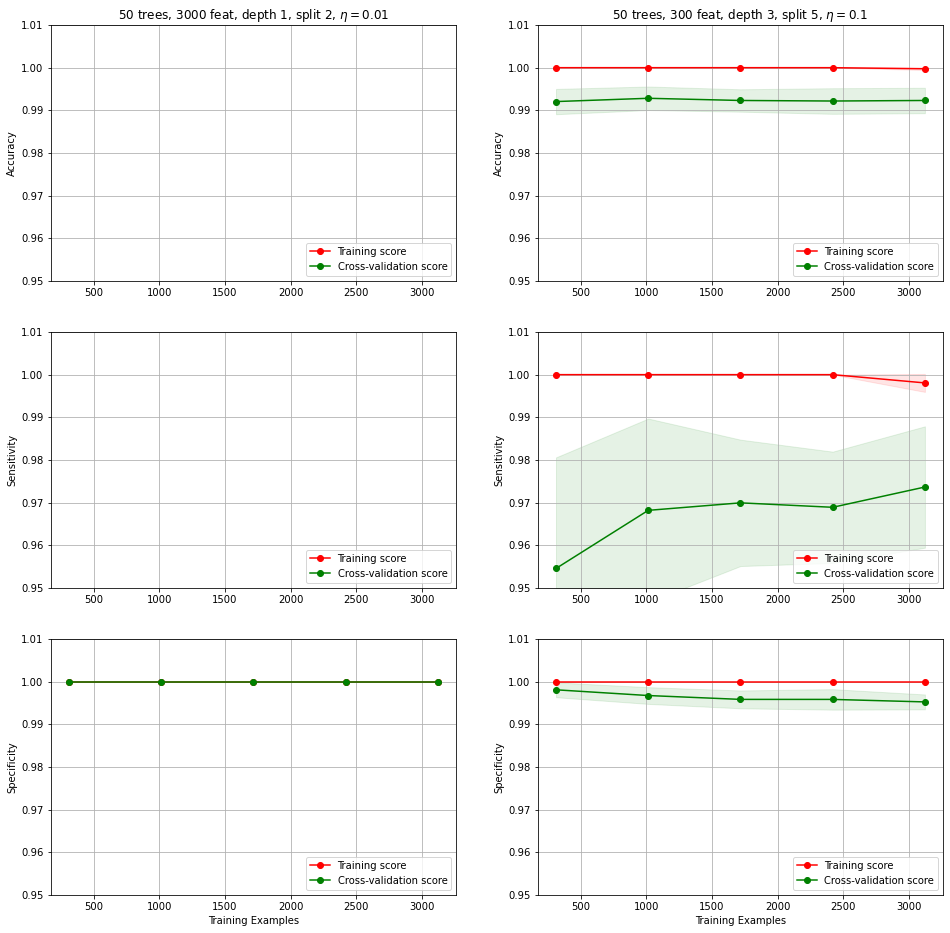

In [13]:
compare_two_classifiers(clf1c, clf2c, title1c, title2c)

In [20]:
# Clf1c predicts ham base rate
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, stratify=y, random_state=42
)
clf1c.fit(X_train, y_train)
y_pred = clf1c.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[677,   0],
       [103,   0]], dtype=int64)

__Results__

- lowering the learning rate in Clf1c made it predict the ham base rate
- there's a *hint of learning* in Clf2c's sensitivity curves now after 2500 training samples

__Next__ 

- original Clf1: raise max depth
- Clf1c tweak: double max features

In [25]:
title1d = r"50 trees, 3000 feat, depth 5, split 2, $\eta=0.1$"
title2d = r"50 trees, 600 feat, depth 3, split 5, $\eta=0.1$"

clf1d = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=3000,
    max_depth=5, # raised
    min_samples_split=2,    
    learning_rate=0.1 
)

clf2d = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100, # ah, mistake
    max_features=600, # raised 
    max_depth=3,
    min_samples_split=5,    
    learning_rate=0.1
)

Elapsed: 20 m 3 s


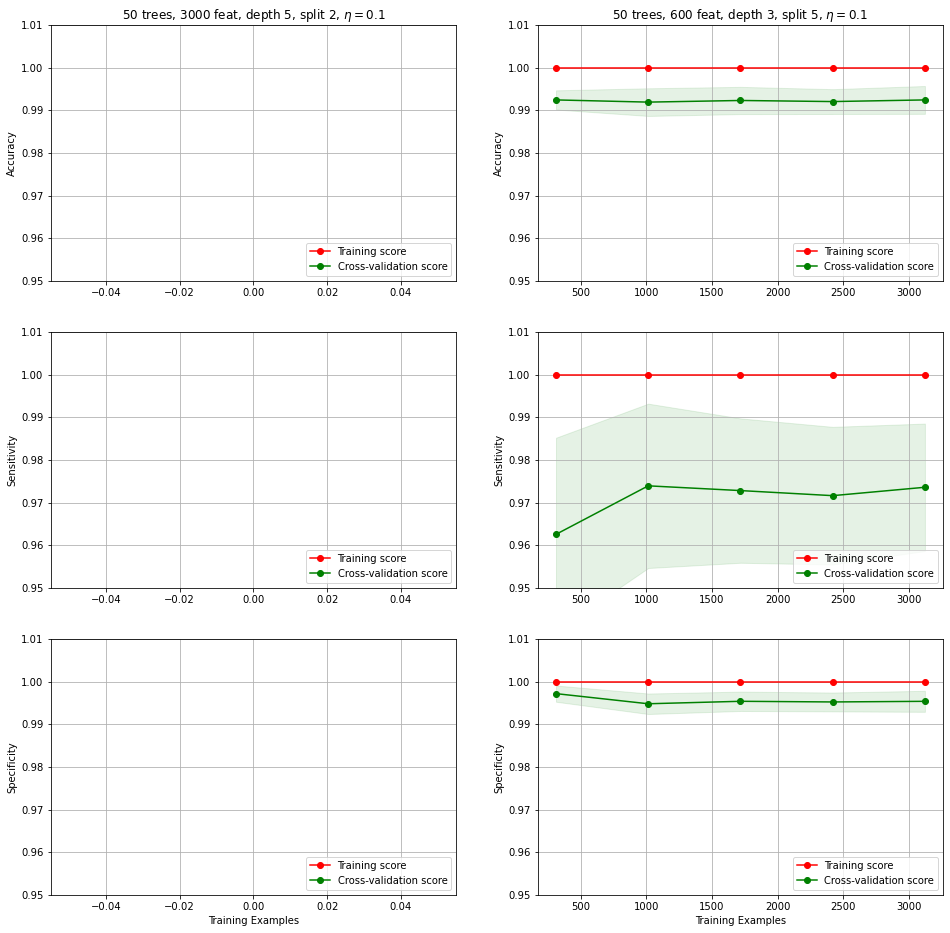

In [26]:
compare_two_classifiers(clf1d, clf2d, title1d, title2d)

In [26]:
4+4

8

__Results__

- The higher depth in Clf1 kills any good results
- The hint at learning in the previous Clf2 disappeared when doubling the number of trees... 
    - nope, I kept the `n_estimators=100` default by mistake

__Next__

- Clf1: Keep original `max_depth=1` and lower `max_features`
- Clf2: Keep `n_estimators=50` and lower `max_features` even further

In [27]:
title1e = r"50 trees, 1000 feat, depth 1, split 2, $\eta=0.1$"
title2e = r"50 trees, 100 feat, depth 3, split 5, $\eta=0.1$"

clf1e = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=1000, # lower
    max_depth=1, 
    min_samples_split=2,    
    learning_rate=0.1 
)

clf2e = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50, 
    max_features=100, # lower
    max_depth=3,
    min_samples_split=5,    
    learning_rate=0.1
)

Elapsed: 2 m 2 s


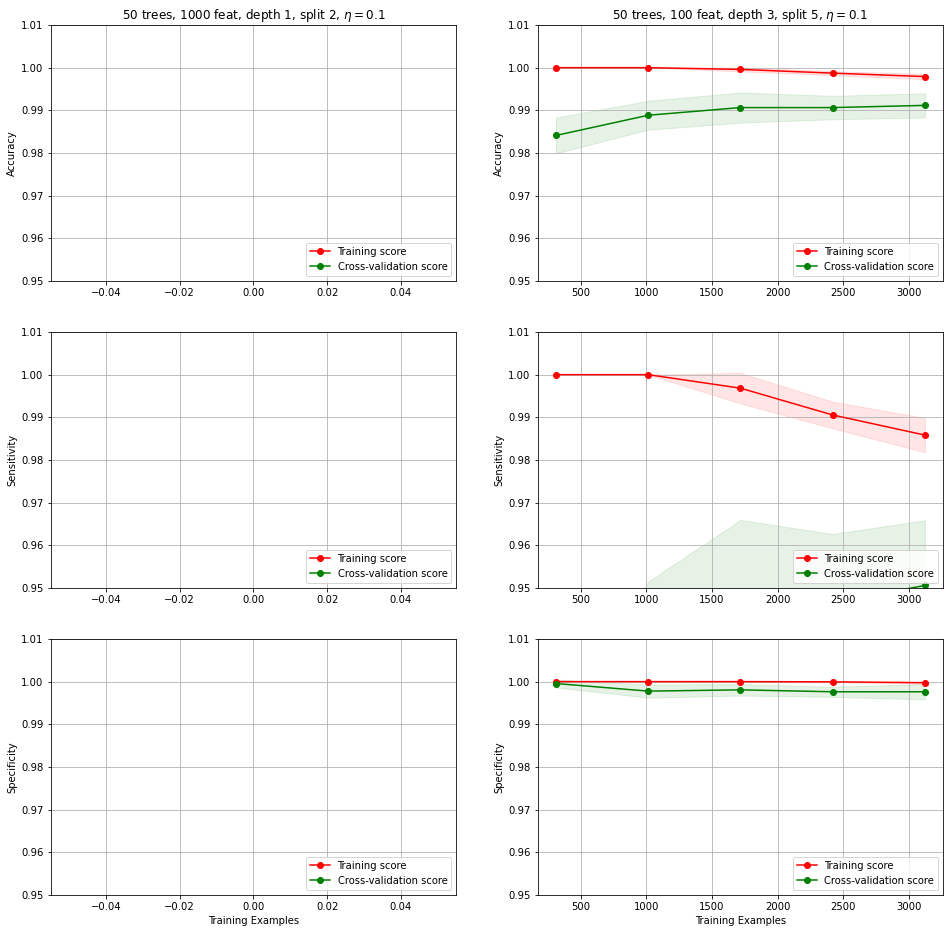

In [28]:
compare_two_classifiers(clf1e, clf2e, title1e, title2e)

__Results__

- Lowering features in Clf1 didn't help it either
- Lowering max features caused less overfitting but also lowered scores 

__Next__

- Clf1: Keep original; double trees... this is an all defaults except for max depth
- Clf2: Keep `n_estimators=50`, double `max_features`, go back to default `min_samples_split=2`

In [29]:
title1f = r"100 trees, 3000 feat, depth 1, split 2, $\eta=0.1$"
title2f = r"50 trees, 100 feat, depth 3, split 5, $\eta=0.1$"

clf1f = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100, # default
    max_features=3000, 
    max_depth=1, # default is 3 (only non-default )
    min_samples_split=2,  
    learning_rate=0.1 
)

clf2f = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50, # half the default
    max_features=200, # doubled
    max_depth=3,
    min_samples_split=2, # default   
    learning_rate=0.1
)

Elapsed: 3 m 23 s


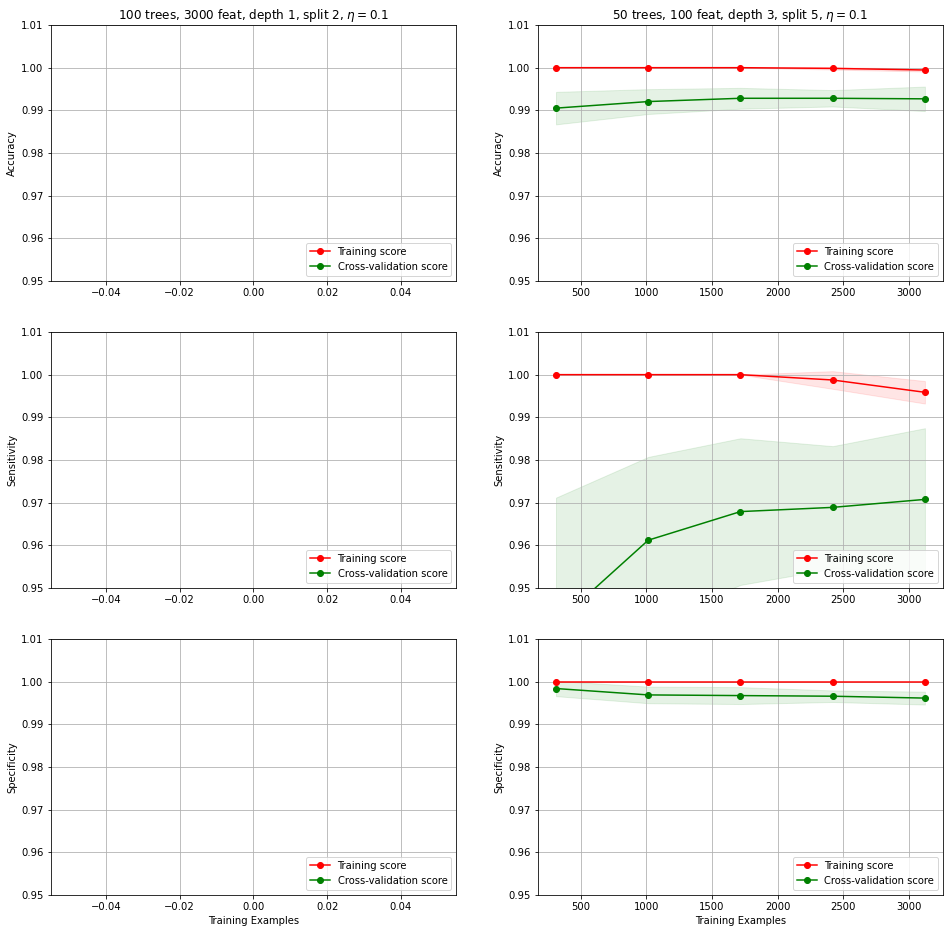

In [30]:
compare_two_classifiers(clf1f, clf2f, title1f, title2f)

__Results__

- interesting how doubling the number of features made it overfit less

__Next__

- realizing I made a mistake before, I go back to doubling the number of features in the second classifier and halving the number of trees
- just testing the second classifier type now, the distinction is artificial anyway, mostly a max depth default and a higher min samples split

In [31]:
title2g = r"50 trees, 600 feat, depth 3, split 5, $\eta=0.1$"
title2h = r"25 trees, 600 feat, depth 3, split 5, $\eta=0.1$"

clf2g = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50, 
    max_features=600, # double
    max_depth=3,
    min_samples_split=5,  
    learning_rate=0.1 
)

clf2h = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25, # half
    max_features=600, # double
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.1
)

Elapsed: 16 m 1 s


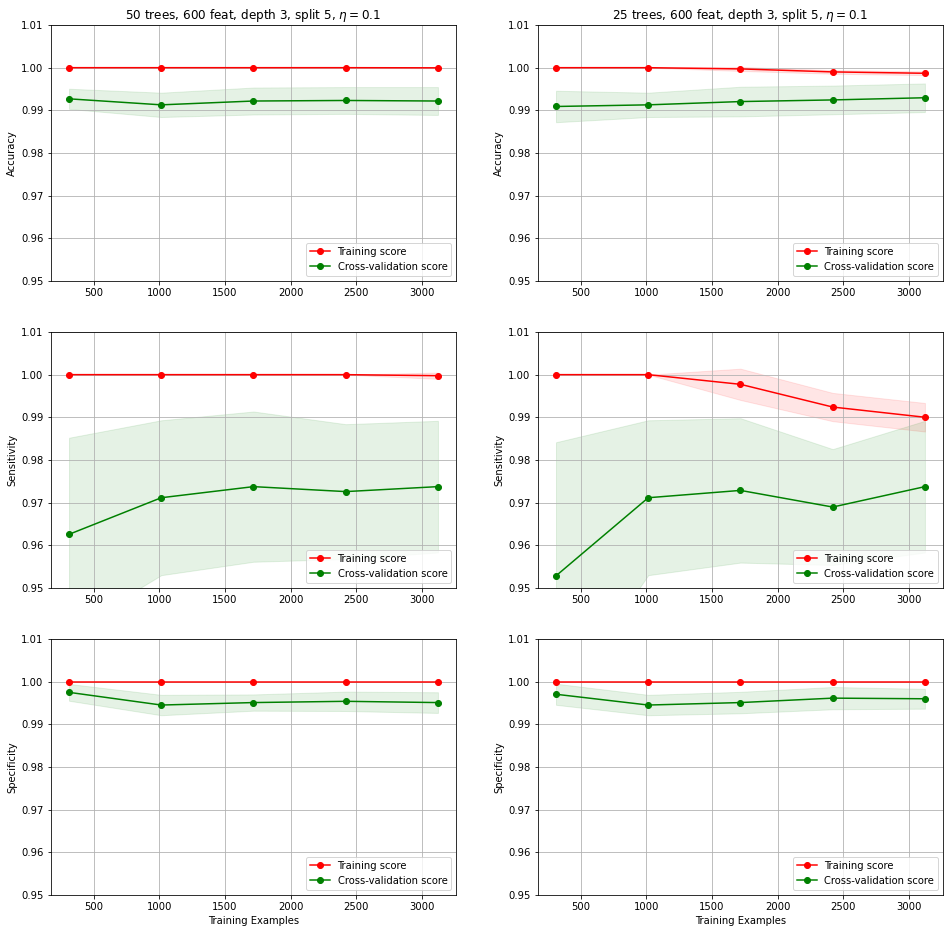

In [32]:
compare_two_classifiers(clf2g, clf2h, title2g, title2h)

In [35]:
title2i = r"50 trees, 1200 feat, depth 3, split 5, $\eta=0.1$"
title2j = r"12 trees, 600 feat, depth 3, split 5, $\eta=0.1$"

clf2i = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25, 
    max_features=1200, # double again
    max_depth=3,
    min_samples_split=5,  
    learning_rate=0.1 
)

clf2j = GradientBoostingClassifier(
    random_state=42,
    n_estimators=12, # half again
    max_features=600, 
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.1
)

Elapsed: 2 m 35 s


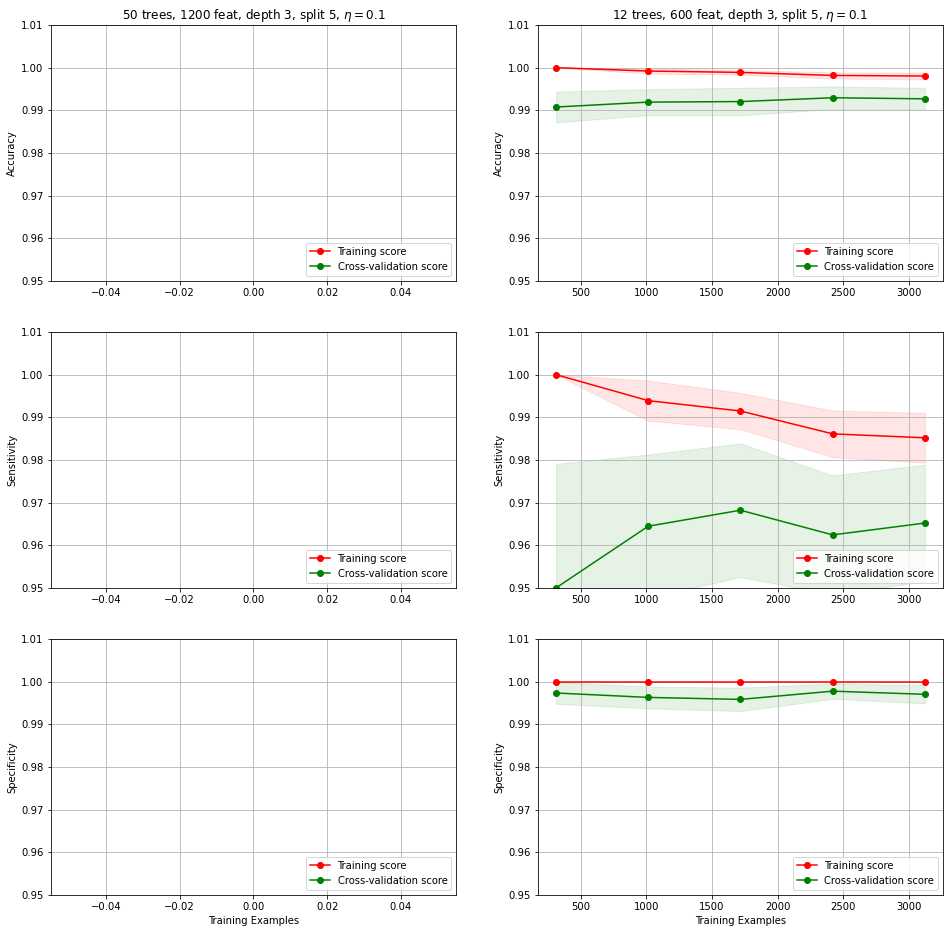

In [36]:
compare_two_classifiers(clf2i, clf2j, title2i, title2j)

In [37]:
title2k = r"25 trees, 300 feat, depth 3, split 5, $\eta=0.1$"
title2l = r"25 trees, 300 feat, depth 3, split 2, $\eta=0.1$"

clf2k = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25, 
    max_features=300, 
    max_depth=3,
    min_samples_split=5,  
    learning_rate=0.1 
)

clf2l = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25,
    max_features=300, 
    max_depth=3,
    min_samples_split=2,
    learning_rate=0.1
)

Elapsed: 5 m 35 s


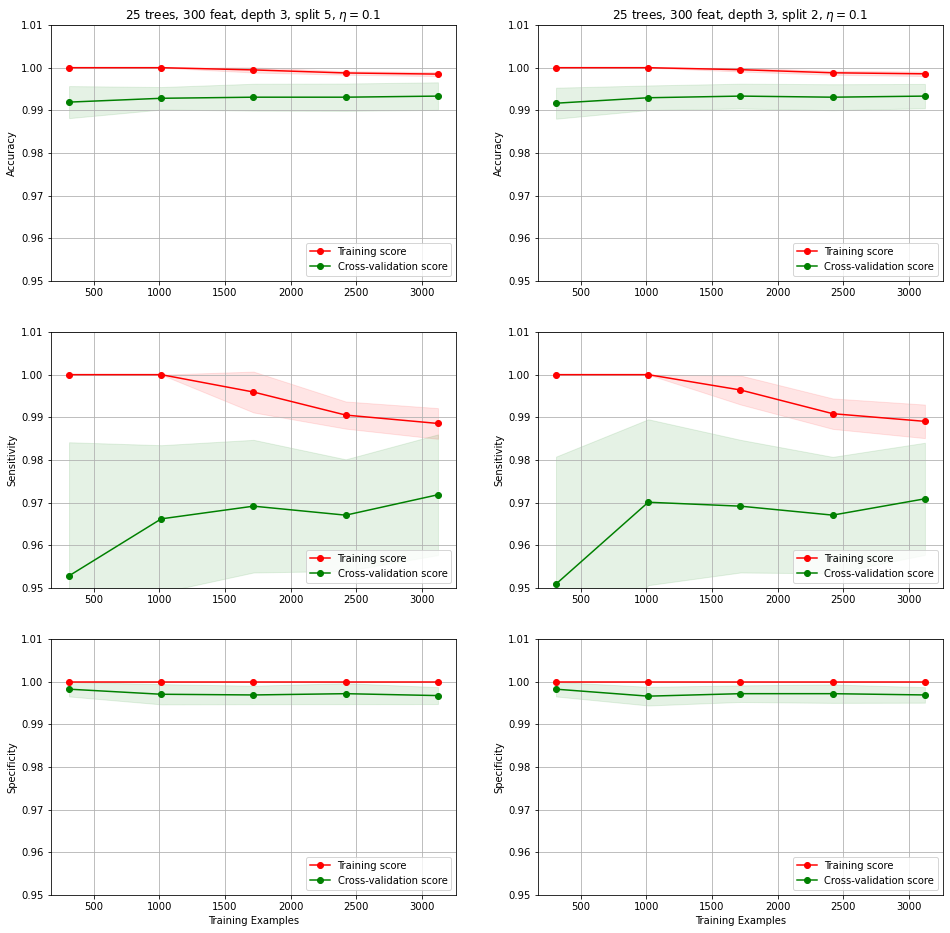

In [38]:
compare_two_classifiers(clf2k, clf2l, title2k, title2l)

In [41]:
title2m = r"25 trees, 150 feat, depth 3, split 5, $\eta=0.1$"
title2n = r"25 trees, 75 feat, depth 3, split 5, $\eta=0.1$"

clf2m = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25, 
    max_features=150, 
    max_depth=3,
    min_samples_split=5,  
    learning_rate=0.1 
)

clf2n = GradientBoostingClassifier(
    random_state=42,
    n_estimators=25,
    max_features=75, 
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.1
)

Elapsed: 2 m 39 s


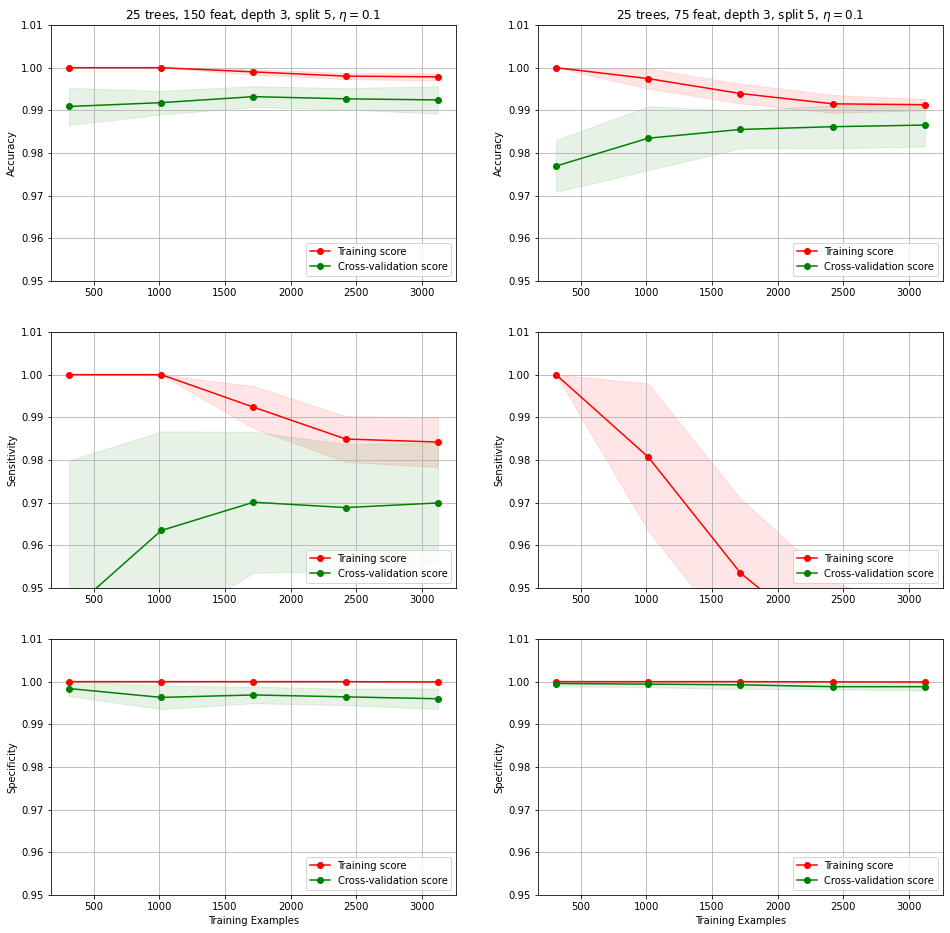

In [42]:
compare_two_classifiers(clf2m, clf2n, title2m, title2n)

---